In [178]:
import os
import numpy as np
from matplotlib import pyplot as plt
import odl
from scipy.io import loadmat

import tifffile as tif

C:\Anaconda3\envs\py36\lib\site-packages\tifffile\tifffile.py:8211: UserWarning: module compiled against API version 0xc but this version of numpy is 0xa
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))


In [179]:
workDir = 'C:\\Users\\bnste\\Documents\\scripts\\odl'
os.chdir(workDir)

rateObj = loadmat("rateObj.mat", squeeze_me = True)
print(rateObj.keys())

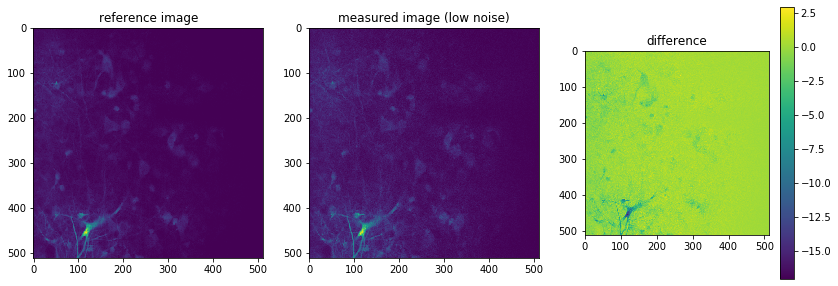

In [768]:

baselvl = .001;


refImg = tif.imread('ref_min.tif')
refMean = refImg.mean()
refImg = refImg / refMean
refImg = np.clip(refImg,baselvl,np.inf)
srcImg = rateObj['resImg']
srcMean = srcImg.mean()
srcImg = srcImg / srcMean
srcImg = np.clip(srcImg,baselvl,np.inf)
#refImg = rateObj['refImg']
#refImg = refImg * (np.mean(srcImg) / np.mean(refImg))
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(refImg); plt.title('reference image')
plt.subplot(1,3,2)
plt.imshow(srcImg); plt.title('measured image (low noise)')
plt.subplot(1,3,3)
plt.imshow(srcImg - refImg); plt.title('difference')
plt.colorbar()

In [769]:
imsize = np.array(srcImg.shape)
imcenter = (imsize-1) / 2
reco_space = odl.uniform_discr( min_pt=-imcenter, max_pt=imcenter, shape=imsize, dtype='float32')

nangles = 8;
angle_partition = odl.uniform_partition(0,np.pi,nangles)
#detector_partition = odl.uniform_partition(min(rateObj['polars']), max(rateObj['polars']), len(rateObj['polars']))
detector_partition = odl.uniform_partition(-imcenter[0],imcenter[0],int(5000 / nangles)) # restrict offsets!
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

ray_trafo = odl.tomo.RayTransform(reco_space, geometry)
fbp_op = odl.tomo.fbp_op(ray_trafo)
fbp_filter_op = odl.tomo.fbp_filter_op(ray_trafo, filter_type='Hamming')

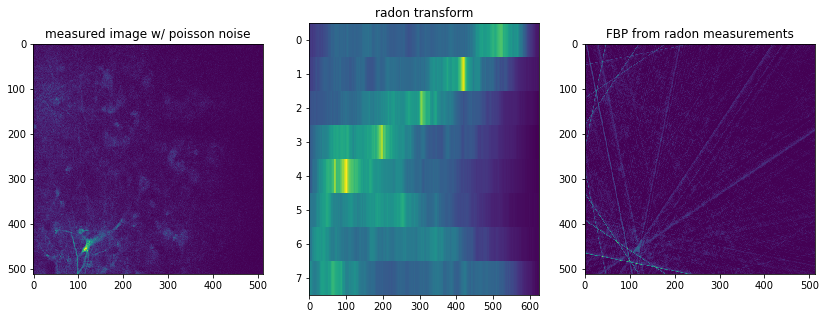

In [770]:
#phantom = odl.phantom.shepp_logan(reco_space, modified=True)
photon_intensity = np.mean(srcImg) / 10; # pixel photon intensity
a = srcImg[srcImg < np.percentile(srcImg,1)]; gauss_sd = np.std(a) # set gaussian noise level
#phantom = reco_space.element(srcImg);
phantom = photon_intensity * reco_space.element(np.random.poisson(np.clip(srcImg / photon_intensity,baselvl / photon_intensity,np.inf)) + (gauss_sd / photon_intensity)* np.random.randn(*srcImg.shape))
proj_data = ray_trafo(phantom)
ref_proj_data = ray_trafo(reco_space.element(refImg))
fbp_img = fbp_op(proj_data)
#fbp_img = fbp_op(fbp_filter_op(proj_data))
fbp_clipped = reco_space.element(np.clip(fbp_img.asarray(),0,np.inf))

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(phantom.asarray()) ; plt.title('measured image w/ poisson noise')
plt.subplot(1,3,2)
plt.imshow(proj_data.asarray(), aspect='auto'); plt.title("radon transform")
plt.subplot(1,3,3)
plt.imshow(fbp_clipped.asarray()); plt.title("FBP from radon measurements")

score_dict = {};

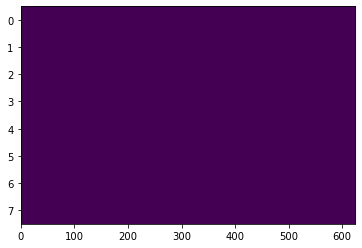

In [771]:
# get support info about sinogram
sptsino = ray_trafo(reco_space.one())
sino_support = sptsino.ufuncs.greater(0)
plt.imshow(sino_support.asarray(), aspect='auto')

norm = 941.3279149532318
norm = 937.8726406097412
norm = 934.4898562431335
norm = 931.1974711418152
norm = 927.9953634738922
norm = 924.8817057609558
norm = 921.8540004491806
norm = 918.9097499847412
norm = 916.0455430746078
norm = 913.2564455270767
norm = 910.5382541418076
norm = 907.8890805244446
norm = 905.3059397935867
norm = 902.7864562273026
norm = 900.3283759355545
norm = 897.9298105239868
norm = 895.5891152620316
norm = 893.3045235872269
norm = 891.0748780965805
norm = 888.8985340595245
norm = 886.7742122411728
norm = 884.7004506587982
norm = 882.6759700775146
norm = 880.6996740102768
norm = 878.7703441381454
norm = 876.8867621421814
norm = 875.0478315353394
norm = 873.252577662468
norm = 871.4999040365219
norm = 869.7889578342438
norm = 868.1187034845352
norm = 866.4882881641388
norm = 864.8967981338501
norm = 863.3430759906769
norm = 861.8262689113617
norm = 860.3453413248062
norm = 858.8993185758591
norm = 857.4872869253159
norm = 856.108515381813
norm = 854.7621511220932
no

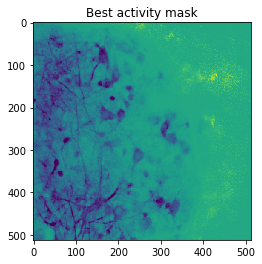

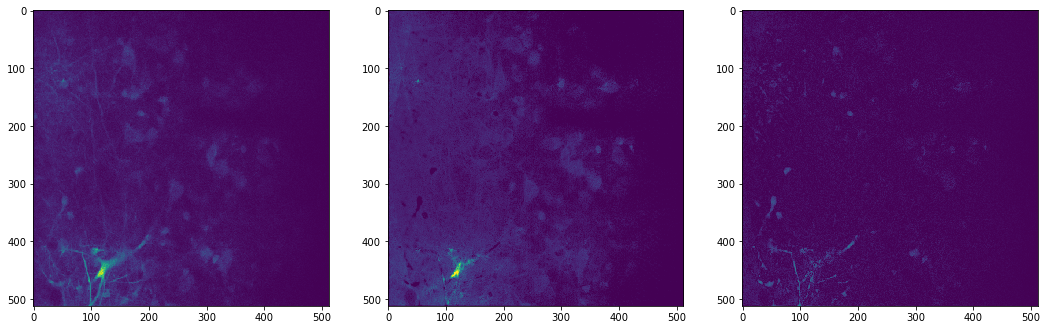

In [874]:
# solve with radon-space matching penalty #

#lam_trials = np.array( [1e-3, 1e-1, 1e1, 1e3])
lam_trials = [1] # weight factor for TV norm
llh_scores = np.zeros_like(lam_trials)
best_lam = -1
best_score = -np.inf
best_x = np.zeros_like(refImg)
gamma_primal = None
gamma_dual = None


penalty = 'kl' # choose 'kl' (poisson-type) or 'l2' (gaussian-type)


pw_mult_op = odl.MultiplyOperator(reco_space.element(refImg))
ray_op = odl.tomo.RayTransform(pw_mult_op.range, geometry, impl='astra_cuda')
#sino_spt_op = odl.MultiplyOperator(ray_op.range.element(sino_support.asarray()));
#ray_op = odl.tomo.RayTransform(reco_space,geometry)


l2_norm = odl.solvers.L2NormSquared(ray_op.range).translated(proj_data)
kl_norm = odl.solvers.KullbackLeibler(ray_op.range, prior = proj_data)


gradient = odl.Gradient(reco_space)

# Column vector of two operators
op = odl.BroadcastOperator(ray_op * pw_mult_op, gradient)


# restrict solution to nonnegative values
f = odl.solvers.IndicatorNonnegativity(reco_space).translated(.001 * reco_space.one())

x = (fbp_img.asarray().mean() / refImg.mean())  * reco_space.one()
# Estimated operator norm, add 10 percent to ensure ||K||_2^2 * sigma * tau < 1
op_norm = 1.1 * odl.power_method_opnorm(op, xstart=x)

niter = 200  # Number of iterations
tau = 1.0 / op_norm  # Step size for the primal variable
sigma = 1.0 / op_norm  # Step size for the dual variable

# Optionally pass callback to the solver to display intermediate results
#testnorm = (odl.solvers.L2NormSquared(reco_space).translated(srcImg)) * pw_mult_op
testnorm = odl.solvers.KullbackLeibler(reco_space, prior = reco_space.element(srcImg)) 
callback = odl.solvers.CallbackPrintNorm()
#callback =  odl.solvers.CallbackShowConvergence(functional=testnorm)


for n,lam in enumerate(lam_trials):

    callback.reset()
    
    #l1_norm = lam * odl.solvers.L1Norm(gradient.range)
    l1_norm = lam * odl.solvers.Huber(gradient.range, gamma=.001)
    
    if penalty == 'l2':
        g = odl.solvers.SeparableSum(l2_norm, l1_norm)
    elif penalty == 'kl':
        g = odl.solvers.SeparableSum(kl_norm, l1_norm)
    else:
        raise Exception('"penalty" should be one of "kl" or "l2"')

    # Choose a starting point
    x = (fbp_clipped.asarray().mean() / refImg.mean())  * reco_space.one()
    #x = fbp_clipped / refImg

    # Run the algorithm
    odl.solvers.pdhg(x, f, g, op, niter=niter, tau=tau, sigma=sigma, gamma_primal = gamma_primal, gamma_dual = gamma_dual ,
                     callback = callback)

    if penalty == 'l2':
        llh_scores[n] = -np.sqrt(((-(x.asarray()*refImg) +srcImg )**2).sum())
    elif penalty == 'kl':
        llh_scores[n] = -testnorm(pw_mult_op(x))
    if llh_scores[n] > best_score:
        best_score = llh_scores[n]
        best_x = x
        best_lam = lam
        best_output = refImg*best_x

        
print('Best L1 penalty multiplier: {:4f}'.format(best_lam))        


plt.figure()
plt.imshow(best_x)
plt.title('Best activity mask')

plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
im=plt.imshow(srcImg)
clim=im.properties()['clim']
plt.subplot(1,3,2)
im=plt.imshow(best_output, clim=clim)
plt.subplot(1,3,3)
plt.imshow(np.abs(srcImg - best_output), clim=clim)

In [859]:
x_biglam = x

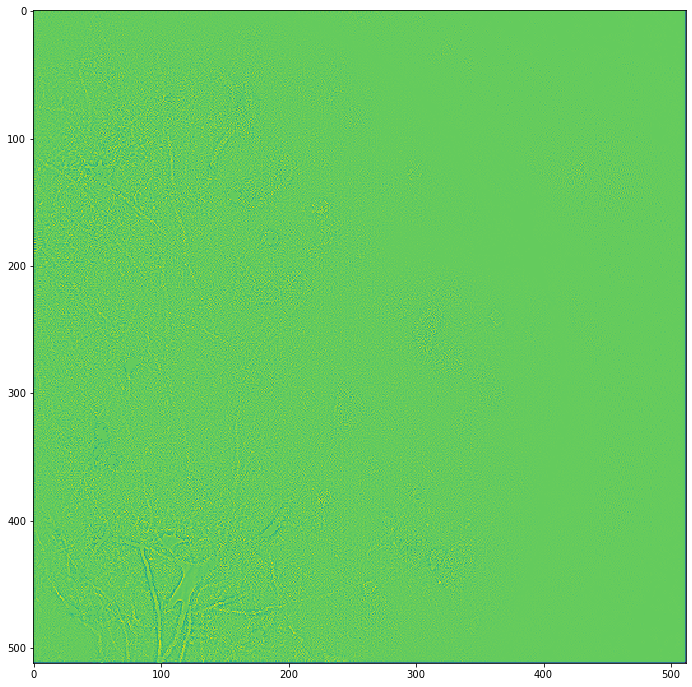

In [872]:
testl1 = odl.solvers.L1Norm(gradient.range)
testl1(gradient(x_biglam))

plt.figure(figsize=(12,12))

plt.imshow(x_biglam - x_smalllam)

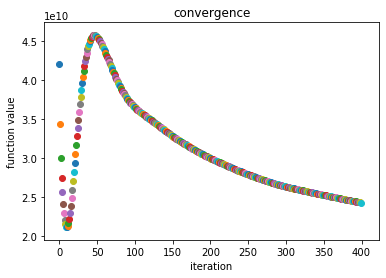

In [676]:
# solve entirely in image space using FBP of measurements #

lam_trials = np.array([1e4])
llh_scores = np.zeros_like(lam_trials)
best_lam = -1
best_score = -np.inf
best_x = np.zeros_like(refImg)
gamma_primal = None
gamma_dual = None

penalty = 'l2' # choose 'kl' (poisson-type) or 'l2' (gaussian-type)


pw_mult_op = odl.MultiplyOperator(reco_space.element(refImg))



l2_norm = odl.solvers.L2NormSquared(pw_mult_op.range).translated(fbp_clipped)
kl_norm = odl.solvers.KullbackLeibler(pw_mult_op.range, prior = fbp_clipped)
   

gradient = odl.Gradient(reco_space)

# Column vector of two operators
op = odl.BroadcastOperator( pw_mult_op, gradient)


# restrict solution to nonnegative values
f = odl.solvers.IndicatorNonnegativity(reco_space)

x = fbp_img.asarray().mean() / refImg.mean()  * reco_space.one()
# Estimated operator norm, add 10 percent to ensure ||K||_2^2 * sigma * tau < 1
op_norm = 1.1 * odl.power_method_opnorm(op, xstart=x)

niter = 400  # Number of iterations
tau = 1.0 / op_norm  # Step size for the primal variable
sigma = 1.0 / op_norm  # Step size for the dual variable

# Optionally pass callback to the solver to display intermediate results
testnorm = (odl.solvers.L2NormSquared(reco_space).translated(srcImg)) * pw_mult_op
callback =  odl.solvers.CallbackShowConvergence(functional=testnorm)

for n,lam in enumerate(lam_trials):


    l1_norm = lam * odl.solvers.L1Norm(gradient.range)
    
    
    if penalty == 'l2':
        g = odl.solvers.SeparableSum(l2_norm, l1_norm)
    elif penalty == 'kl':
        g = odl.solvers.SeparableSum(kl_norm, l1_norm)
    else:
        raise Exception('"penalty" should be one of "kl" or "l2"')

    # Choose a starting point
    x = fbp_clipped.asarray().mean() / refImg.mean()  * reco_space.one()


    # Run the algorithm
    odl.solvers.pdhg(x, f, g, op, niter=niter, tau=tau, sigma=sigma, gamma_primal = gamma_primal, gamma_dual = gamma_dual ,
                     callback = callback)

    if penalty == 'l2':
        llh_scores[n] = -np.sqrt(((-(x.asarray()*refImg) +srcImg )**2).sum())
    elif penalty == 'kl':
        llh_scores[n] = -np.sqrt(((-(x.asarray()*refImg) +srcImg )**2).sum())
    if llh_scores[n] > best_score:
        best_score = llh_scores[n]
        best_x = x
        best_lam = lam
        best_output = refImg*best_x
    

In [666]:
print(best_lam)
plt.semilogx(lam_trials,llh_scores)

36.81391399371887

In [459]:
llh_scores

array([ -6.23913886e+08,  -6.23913886e+08,  -6.23913886e+08,
        -6.23913886e+08,  -6.23913886e+08,  -6.23913886e+08,
        -6.23913886e+08,  -6.23913886e+08,  -6.23913886e+08,
        -6.23913886e+08,  -6.23913886e+08,  -6.23913886e+08,
        -6.23913886e+08,  -6.23913886e+08,  -6.23913886e+08,
        -6.23913822e+08,  -6.23913822e+08])

-1


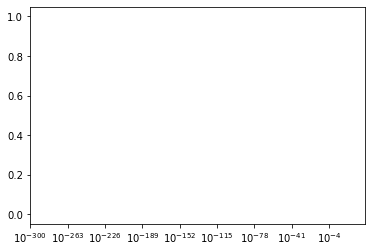

In [375]:
print(best_lam)
plt.semilogx(lam_trials,llh_scores)

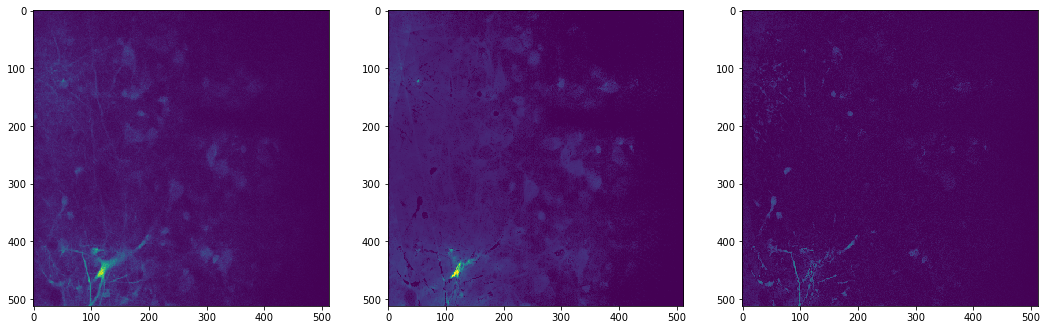

In [786]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
im=plt.imshow(srcImg)
clim=im.properties()['clim']
plt.subplot(1,3,2)
im=plt.imshow(best_output, clim=clim)
plt.subplot(1,3,3)
plt.imshow(np.abs(srcImg - best_output), clim=clim)

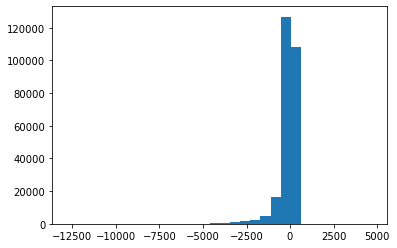

In [289]:
plt.hist((srcimg - best_output.asarray()).flatten(), 30);

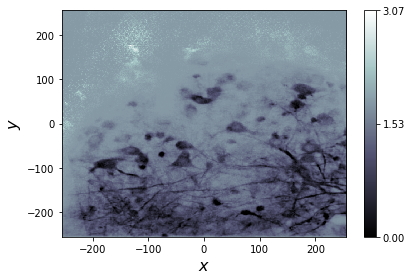

<Figure size 432x288 with 0 Axes>

In [782]:
x.show();

In [309]:
radfft = odl.trafos.DiscreteFourierTransform(ray_trafo.range,axes=1)
invfft = odl.trafos.
tmp = radfft(proj_data)

In [372]:
myl1 = l1_norm(gradient(best_x))
fullop = ray_op * pw_mult_op
mypw = pw_mult_op(best_x)
myray = ray_op(mypw)
myerr = kl_norm(myray+10)


In [373]:
myerr

3880117.741770543

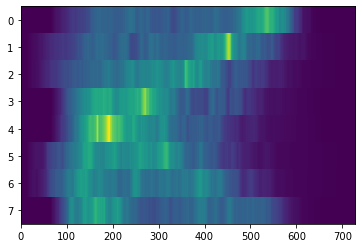

In [348]:
plt.imshow(myray, aspect='auto')

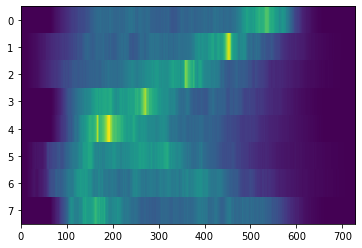

In [349]:
plt.imshow(proj_data, aspect='auto')

In [479]:
import odl.contrib.solvers.spdhg as spdhg

In [783]:
# errors for radon-space algorithm
smoothErr = l1_norm(gradient(best_x));
targetErr = l2_norm(ray_op(pw_mult_op(best_x)))
print('Log 10 Smoothing error: {}'.format(np.log10(smoothErr)))
print('Log 10 Target error: {}'.format(np.log10(targetErr)))

Log 10 Smoothing error: 24.42510132401401
Log 10 Target error: 6.390416478516338


In [657]:
# errors for image-space algorithm
smoothErr = l1_norm(gradient(best_x));
targetErr = l2_norm((pw_mult_op(best_x)))
print('Log 10 Smoothing error: {}'.format(np.log10(smoothErr)))
print('Log 10 Target error: {}'.format(np.log10(targetErr)))

Log 10 Smoothing error: 10.46587368369768
Log 10 Target error: 10.67287738215972


In [730]:
kl_norm(sino_spt_op(ray_op.range.one()))

inf

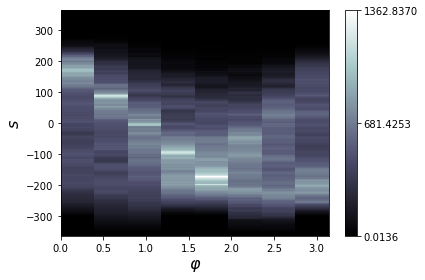

<Figure size 432x288 with 0 Axes>

In [724]:
(sino_spt_op*ray_op * pw_mult_op)(x).show();

In [794]:
refImg.min()

0.001

In [793]:
x = reco_space.one()
test_pred = ray_op(pw_mult_op(x))
test_val = kl_norm(test_pred)
test_val

33716.84298038314

Best L1 penalty multiplier: 0.000000


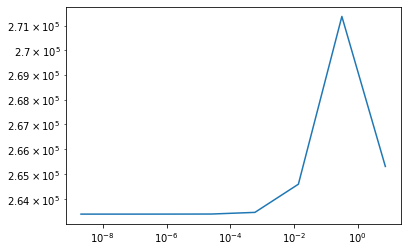

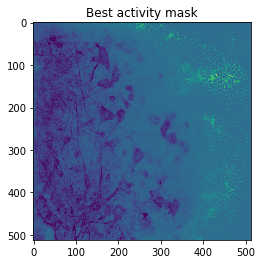

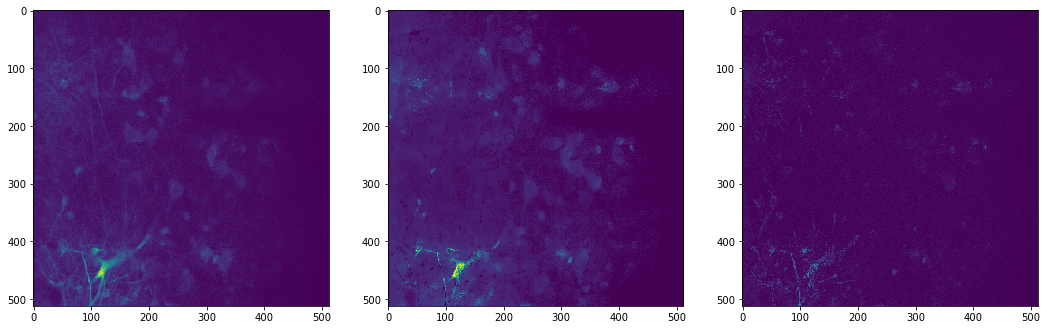

In [904]:
# solve with radon-space matching penalty. use FISTA #

#lam_trials = np.array( [1e-3, 1e-1, 1e1, 1e3])
lam_trials = np.exp(np.linspace(-20,2,8)) # weight factor for TV norm
llh_scores = np.zeros_like(lam_trials)
best_lam = -1
best_score = -np.inf
best_x = np.zeros_like(refImg)
gamma = .0001 # step size


high_src_vals = srcImg > np.percentile(srcImg,5)

pw_mult_op = odl.MultiplyOperator(reco_space.element(refImg))
ray_op = odl.tomo.RayTransform(pw_mult_op.range, geometry, impl='astra_cuda')
#sino_spt_op = odl.MultiplyOperator(ray_op.range.element(sino_support.asarray()));
#ray_op = odl.tomo.RayTransform(reco_space,geometry)


l2_norm = odl.solvers.L2NormSquared(ray_op.range).translated(proj_data)
kl_norm = odl.solvers.KullbackLeibler(ray_op.range, prior = proj_data)



gradient = odl.Gradient(reco_space)

# Column vector of two operators
op = odl.BroadcastOperator( odl.IdentityOperator(reco_space), gradient)


# restrict solution to nonnegative values
indicator = odl.solvers.IndicatorNonnegativity(reco_space).translated(.001 * reco_space.one())


niter = 400  # Number of iterations


# Optionally pass callback to the solver to display intermediate results
#testnorm = (odl.solvers.L2NormSquared(reco_space).translated(srcImg)) * pw_mult_op
testnorm = odl.solvers.KullbackLeibler(reco_space, prior = reco_space.element(srcImg)) 
callback = odl.solvers.CallbackPrintNorm()
#callback =  odl.solvers.CallbackShowConvergence(functional=testnorm)


for n,lam in enumerate(lam_trials):
    
    callback.reset()

    grad_l1_norm = (lam * odl.solvers.Huber(gradient.range,gamma=.001))*gradient
    g = (kl_norm * ray_op * pw_mult_op) +  grad_l1_norm

    f =  indicator 

    # Choose a starting point
    x = (fbp_clipped.asarray().mean() / refImg.mean())  * reco_space.one()
    #x = fbp_clipped / refImg

    # Run the algorithm
    odl.solvers.accelerated_proximal_gradient(x, f, g, gamma = gamma, niter = niter, callback = None)


    output = refImg * x.asarray()
    llh_scores[n] = -(output + srcImg * np.log(output) )[high_src_vals].sum()
    if llh_scores[n] > best_score:
        best_score = llh_scores[n]
        best_x = x
        best_lam = lam
        best_output = output

        
print('Best L1 penalty multiplier: {:4f}'.format(best_lam))        

plt.figure()
plt.loglog(lam_trials,-llh_scores)


plt.figure()
plt.imshow(best_x)
plt.title('Best activity mask')

plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
im=plt.imshow(srcImg)
clim=im.properties()['clim']
plt.subplot(1,3,2)
im=plt.imshow(best_output, clim=clim)
plt.subplot(1,3,3)
plt.imshow(np.abs(srcImg - best_output), clim=clim)

In [896]:
srcImg.mean()

1.000077038681602

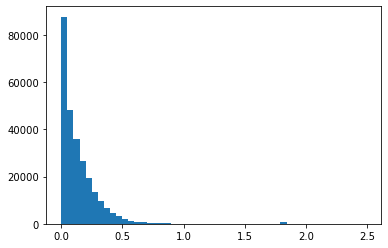

0.0938281565905


In [833]:
a=gradient(x_smalllam).asarray()
grad_norms = np.sqrt((a**2).sum(axis=0)).flatten();
plt.hist(grad_norms,50)
plt.show()
print(np.percentile(grad_norms,50))